In [1]:
from util import *
from sklearn import metrics
from sklearn.linear_model import SGDClassifier as LogisticRegression
from sklearn.model_selection import train_test_split
import sys
import pickle
import os.path

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

NUM_DATA_BATCHES = 100
OPTIMAL_ITERS = 100
NUM_ITERS   = 100
NUM_REPEATS = 3

In [2]:
train_data, train_labels = load('trainingVectors.csv')
print(train_data.shape)
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.25)

(10383, 200)


In [3]:
# each batch includes all data up to and including current index.
def load_optimal_batches(data, labels, num_batches):
    batch_size = int(data.shape[0] / num_batches)
    data_batches = []
    label_batches = []
    for i in range(num_batches):
        k = (i + 1) * batch_size
        data_batches.append(data[:k])
        label_batches.append(labels[:k])
    return data_batches, label_batches

# each batch includes only that subset's data.
def load_incremental_batches(data, labels, num_batches):
    batch_size = int(data.shape[0] / num_batches)
    data_batches = []
    label_batches = []
    for i in range(num_batches):
        k = i * batch_size
        data_batches.append(data[k:k+batch_size])
        label_batches.append(labels[k:k+batch_size])
    return data_batches, label_batches

In [4]:
class Trial:
    def __init__(self, reg_param, num_iterations, eta0, num_data_batches, num_repeats, timed=False):
        self.metrics = Metrics(train_labels, test_labels)
        self.reg_param = reg_param
        self.num_iterations = num_iterations
        self.eta0 = eta0
        self.timed = timed
        self.num_repeats = num_repeats
        self.num_data_batches = num_data_batches
        self.load_data()
        
    def load_data(self):
        raise NotImplementedError
        
    def run_trials(self, num_runs):
        self.setup_trials()
        for i in range(num_runs):
            # shuffle(train_data, train_labels) Need to make data global
            if not self.timed:
                self.metrics.start_run()
                
            self.run_trial()
            
            if not self.timed:
                self.metrics.finish_run()
        return self.metrics
        
    def run_trial(self):
        raise NotImplementedError
        
    def setup_trials(self):
        return     

In [5]:
class BaselineTrial(Trial):
    def load_data(self):
        self.data_batches, self.label_batches = load_optimal_batches(train_data, train_labels, num_data_batches)
        
    def run_trial(self):
        for i in range(self.num_data_batches * self.num_repeats):
            ind = min(i, self.num_data_batches - 1)
            data = self.data_batches[ind]
            labels = self.label_batches[ind]
            
            # no need to retrain if we've already seen all data
            if i < self.num_data_batches:
                model = LogisticRegression(loss='log', alpha=self.reg_param,
                                      n_iter=self.num_iterations,
                                      eta0=self.eta0,
                                      learning_rate='optimal',
                                      warm_start=False)
                model = model.fit(data, labels)
                
            # append predictions
            if not self.timed:
                train_predictions = model.predict(train_data)
                test_predictions = model.predict(test_data)
                self.metrics.add_predictions(train_predictions, test_predictions)

In [6]:
class ReservoirTrial(Trial):
    def __init__(self, reg_param, num_iterations, eta0, num_data_batches, num_repeats, 
                 reservoir_size, timed=False, force_warm=True):
        super().__init__(reg_param, num_iterations, eta0, num_data_batches, num_repeats, timed)
        self.reservoir_size = reservoir_size
        self.force_warm = force_warm
        
    def load_data(self):
        self.data_batches, self.label_batches = load_incremental_batches(train_data, train_labels, num_data_batches)

    def setup_trials(self):
        self.data_reservoir = np.random.rand(self.reservoir_size, train_data.shape[1])
        self.labels_reservoir = np.random.choice(np.unique(train_labels), size=self.reservoir_size)
        self.reservoir_index = 0
    
    def run_trial(self):
        for i in range(self.num_data_batches * self.num_repeats):
            # load data for the current batch
            ind = i % self.num_data_batches
            data = self.data_batches[ind]
            labels = self.label_batches[ind]
            
            # reservoir sampling procedure
            self.reservoir_index += 1
            indices = np.random.randint(self.reservoir_index, size=data.shape[0])
            indices_to_keep = indices[indices < self.reservoir_size]
            k = 0
            for index in indices_to_keep:
                self.data_reservoir[index] = data[k % data.shape[0]]
                self.labels_reservoir[index] = labels[k % labels.shape[0]]
                k += 1
                
            # check whether or not to use a warm start for model weights
            warm = i != 0 or self.force_warm
            
            # create and train the model
            model = LogisticRegression(loss='log', alpha=self.reg_param,
                                      n_iter=self.num_iterations,
                                      eta0=self.eta0,
                                      learning_rate='optimal',
                                      warm_start=warm)
            
            model = model.fit(self.data_reservoir, self.labels_reservoir)

                
            # append predictions for metrics calculations
            if not self.timed:
                train_predictions = model.predict(train_data)
                test_predictions = model.predict(test_data)
                self.metrics.add_predictions(train_predictions, test_predictions)

In [7]:
class ModelAveragingTrial(Trial):
    def __init__(self, reg_param, num_iterations, eta0, num_data_batches, num_repeats, 
                 timed=False, force_warm=False):
        super().__init__(reg_param, num_iterations, eta0, num_data_batches, num_repeats, timed)
        self.force_warm = force_warm
    
    def load_data(self):
        self.data_batches, self.label_batches = load_incremental_batches(train_data, train_labels, num_data_batches)
    
    def update_model(self, model, n):
        if n == 1:
            self.coef = model.coef_
            self.intercept = model.intercept_
        
        coef = model.coef_
        intercept = model.intercept_
        
        avg_coef = (coef + n * self.coef) / (n+1)
        avg_int = (intercept + n * self.intercept) / (n+1)
        
        model.coef_ = avg_coef
        model.intercept = avg_int
        
        self.coef = avg_coef
        self.intercept = avg_int
    
    def run_trial(self):
        self.coef = None
        self.intercept = None
        n = 1
        
        for i in range(self.num_data_batches * self.num_repeats):
            # load data for the current batch
            ind = i % self.num_data_batches
            data = self.data_batches[ind]
            labels = self.label_batches[ind]

            model = LogisticRegression(loss='log', alpha=self.reg_param,
                                      n_iter=self.num_iterations,
                                      eta0=self.eta0,
                                      learning_rate='optimal',
                                      warm_start=self.force_warm and i != 0)
            model = model.fit(data, labels)

            # perform model averaging update
            self.update_model(model, n)
            n += 1

            # track prediction metrics
            if not self.timed:
                train_predictions = model.predict(train_data)
                test_predictions = model.predict(test_data)
                self.metrics.add_predictions(train_predictions, test_predictions)
                

In [13]:
### Testing parameters
opt_reg_param = 0.001
opt_num_runs = 1
opt_eta0 = 1.0

reg_param = 0.005
eta0 = 5.0

num_data_batches = 100
opt_num_iterations = 100
num_iterations = 100

reservoir_size = 500

num_repeats = 3

num_runs = 5

# save filenames
opt_metrics_fname = 'optimal_metrics.pkl'
reservoir_metrics_fname = 'reservoir_metrics.pkl'
model_avg_metrics_fname = 'model_avg_metrics.pkl'

Run the following to erase saved models:

In [113]:
%%bash
rm -f *.pkl

Generate trial results:

In [9]:
### Optimal run
if os.path.exists(opt_metrics_fname):
    optimal_metrics = pickle.load(open(opt_metrics_fname, 'rb'))
else:
    optimal_trial = BaselineTrial(opt_reg_param, opt_num_iterations, opt_eta0, num_data_batches, num_repeats, timed=False)
    optimal_metrics = optimal_trial.run_trials(opt_num_runs)
    pickle.dump(optimal_metrics, open(opt_metrics_fname, 'wb'), pickle.HIGHEST_PROTOCOL)

optimal_metrics.calculate_metrics()

In [10]:
### Reservoir sampling run
if os.path.exists(reservoir_metrics_fname):
    reservoir_metrics = pickle.load(open(reservoir_metrics_fname, 'rb'))
else:
    reservoir_trial = ReservoirTrial(reg_param, num_iterations, eta0, num_data_batches, num_repeats, reservoir_size=reservoir_size, timed=False)
    reservoir_metrics = reservoir_trial.run_trials(num_runs)
    pickle.dump(reservoir_metrics, open(reservoir_metrics_fname, 'wb'), pickle.HIGHEST_PROTOCOL)

reservoir_metrics.calculate_metrics()

In [19]:
### Model averaging run
if os.path.exists(model_avg_metrics_fname):
    model_avg_metrics = pickle.load(open(model_avg_metrics_fname, 'rb'))
else:
    model_avg_trial = ModelAveragingTrial(reg_param, num_iterations, eta0, num_data_batches, num_repeats, timed=False, force_warm=False)
    model_avg_metrics = model_avg_trial.run_trials(num_runs)
    pickle.dump(model_avg_metrics, open(model_avg_metrics_fname, 'wb'), pickle.HIGHEST_PROTOCOL)
    
model_avg_metrics.calculate_metrics()

Populating the interactive namespace from numpy and matplotlib


/home/noah/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


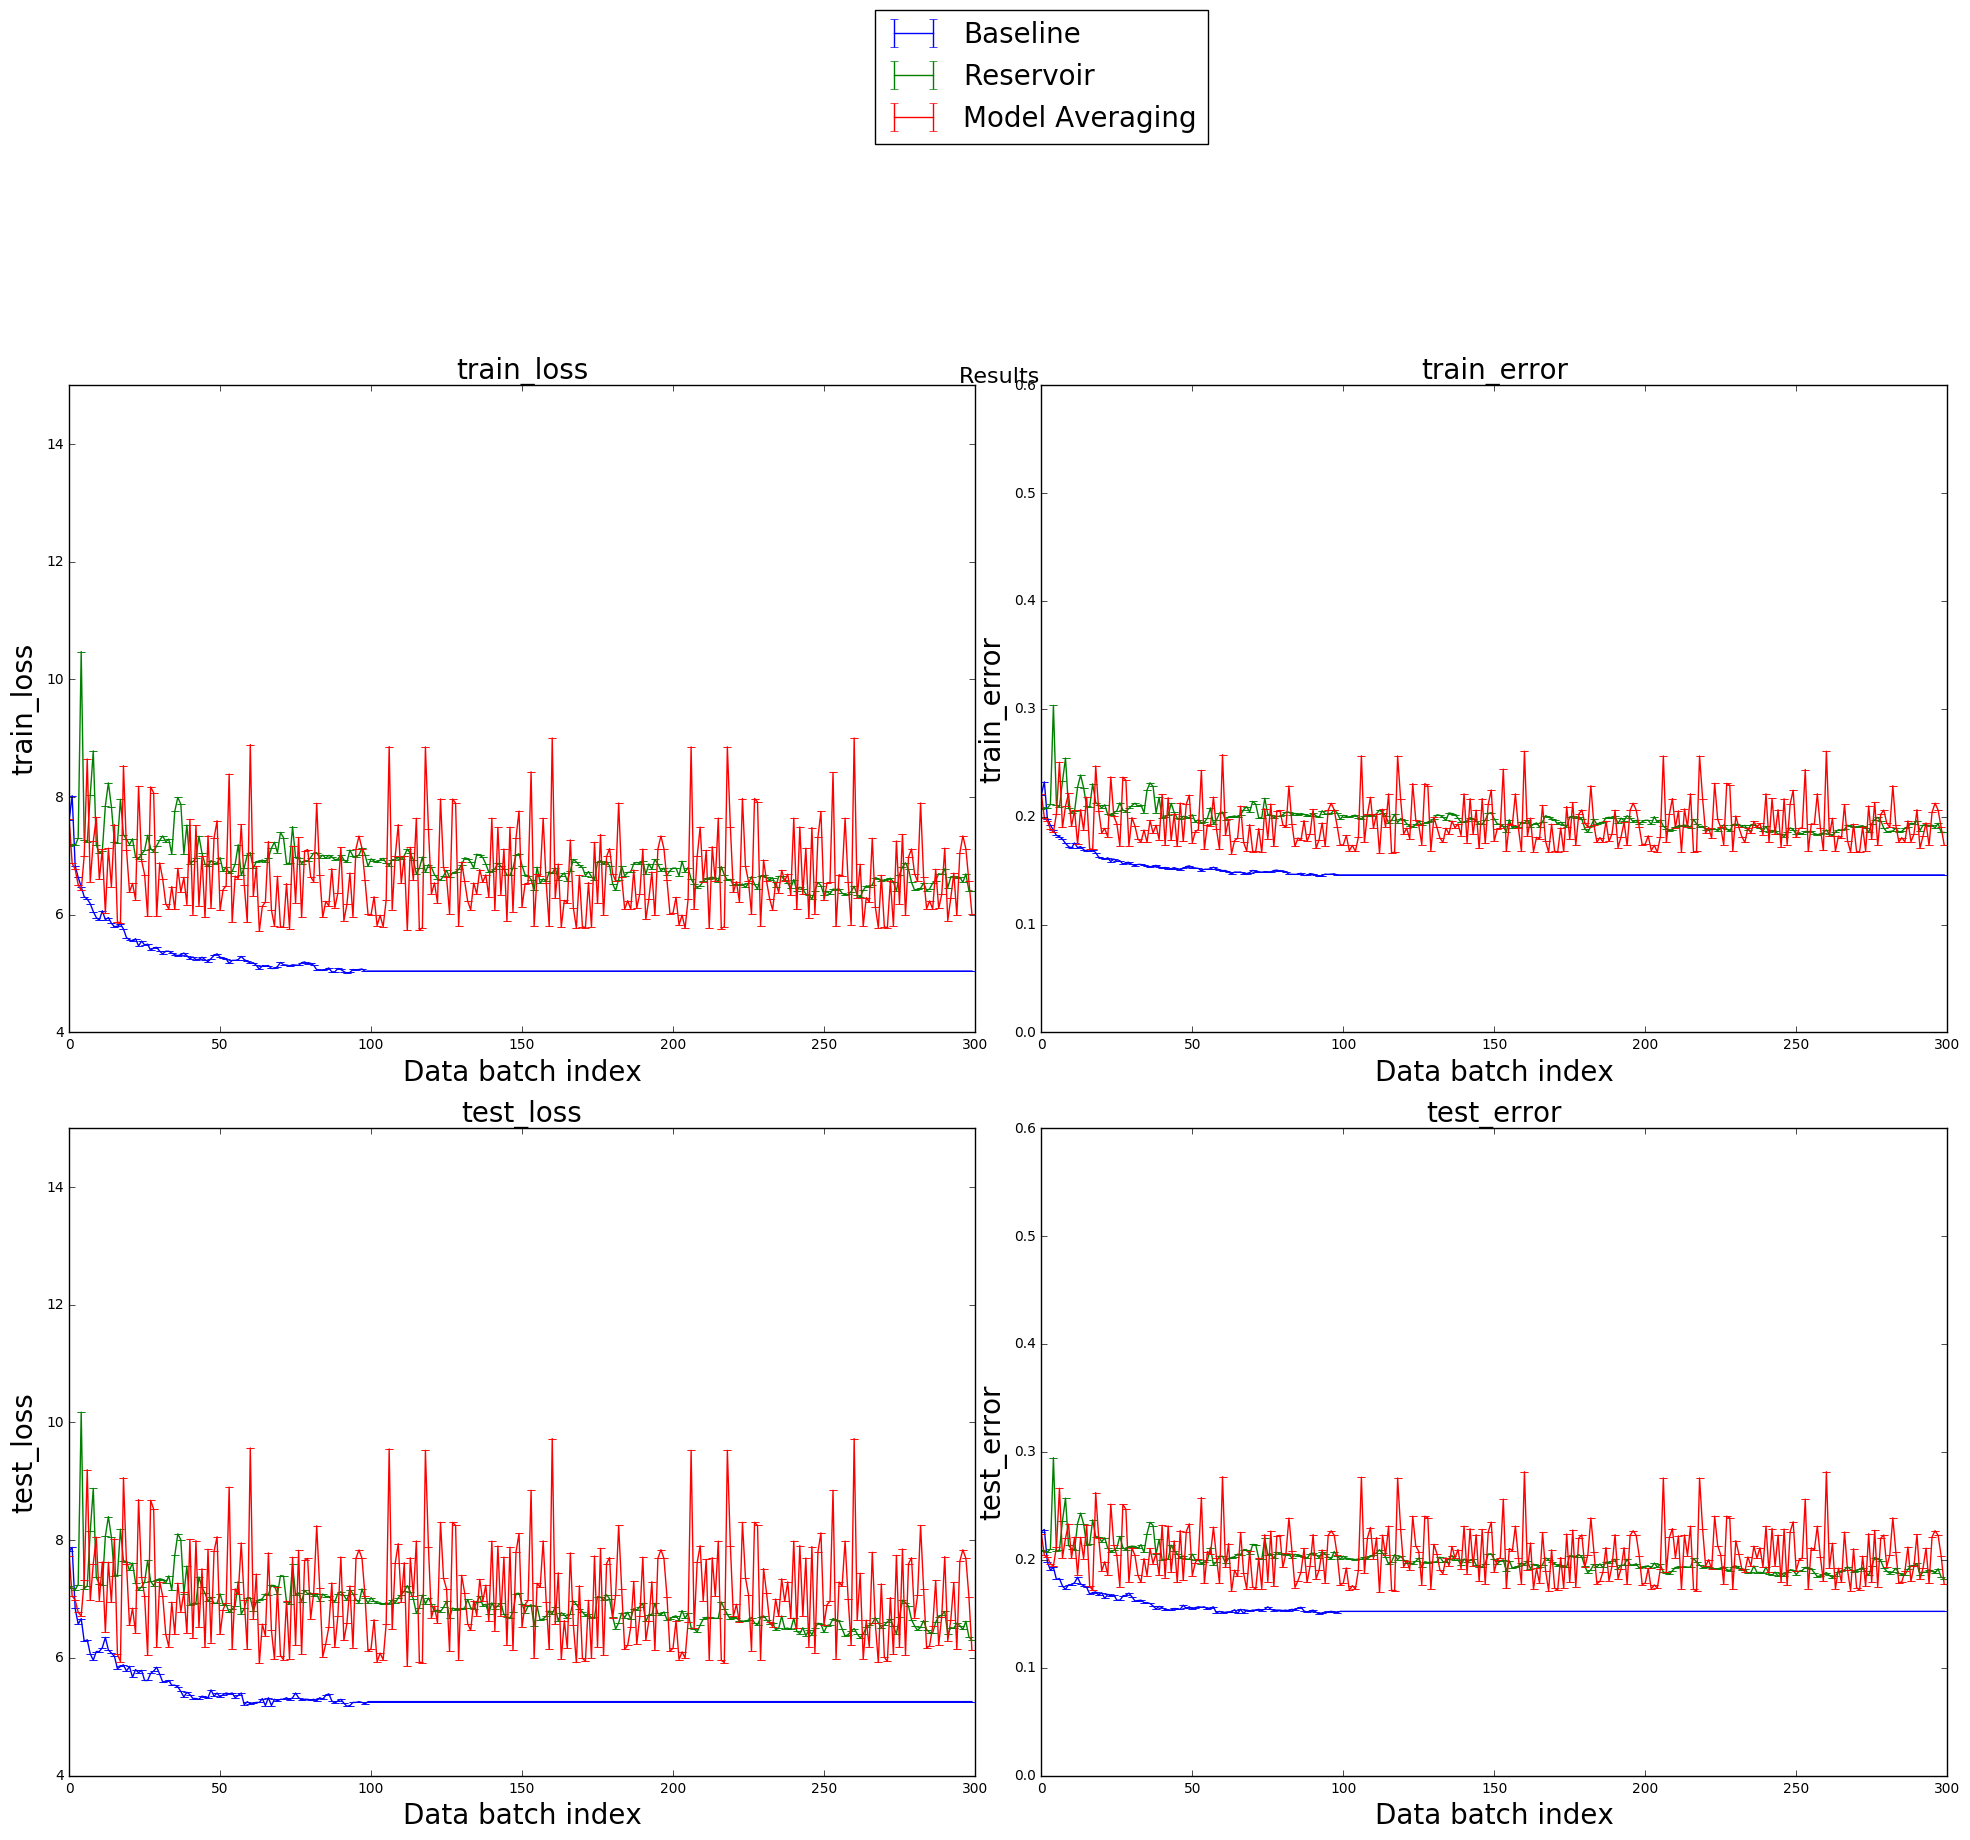

In [25]:
### Plot the different models
display_indices = list(range(num_data_batches * num_repeats))

% pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False)

plt.tight_layout(pad=3.0, w_pad=2.0, h_pad=5.0)

labels = ['Baseline', 'Reservoir', 'Model Averaging']
metrics = [optimal_metrics, reservoir_metrics, model_avg_metrics]

def plot(ax, metrics, attribute, labels, show_errors=False):
    for metric, label in zip(metrics, labels):
        line, errors = getattr(metric, attribute)
        if not show_errors:
            errors = 0
            
        ax.errorbar(display_indices, line, yerr=errors, label=label)
        ax.set_xlabel('Data batch index', fontsize=20)
        ax.set_ylabel(attribute[:-5], fontsize=20)
        ax.set_title(attribute[:-5], fontsize=20)
        
plot(axs[0, 0], metrics, 'train_loss_data', labels)
plot(axs[0,1], metrics, 'train_error_data', labels)
plot(axs[1,0], metrics, 'test_loss_data', labels)
plot(axs[1,1], metrics, 'test_error_data', labels)

# limit axes
# set the same bounds
axs[0,1].set_ylim([0,0.6])
axs[1,1].set_ylim([0,0.6])
axs[1,0].set_ylim([4,15])
axs[0,0].set_ylim([4,15])

plt.legend(loc='lower center', bbox_to_anchor=(0, 2.5), fontsize=20)
fig.suptitle('Results', fontsize=16)
plt.show()